<a href="https://colab.research.google.com/github/T0gan/KTHack2020---Neural-Qubits/blob/main/QCNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 6.7MB/s 
     |████████████████████████████████| 5.6MB 27.0MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [ ]:
!pip install cirq

In [ ]:
import tensorflow as tf 
import tensorflow_quantum as tfq 
import cirq 
import sympy 
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12049
Number of filtered test examples: 1968


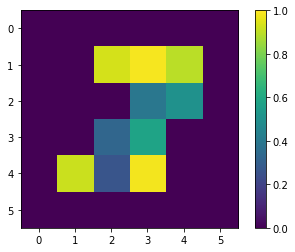

In [ ]:
#import data
import collections

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

x_train_small = tf.image.resize(x_train, (6,6)).numpy()
x_test_small = tf.image.resize(x_test, (6,6)).numpy()

def convert_label(y):
  if y==True:
    return 1.0
  else: 
    return -1.0

y_train=[convert_label(y) for y in y_train]
y_test=[convert_label(y) for y in y_test]

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

X_train=x_train_small[:100]
X_test=x_test_small[:20]
Y_train=y_train[:100]
Y_test=y_test[:20]

In [ ]:
from sympy.physics.quantum import TensorProduct


def one_qubit_unitary(bit, symbols):

    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])

    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]


    circuit+=one_qubit_unitary(bits[0], symbols[9:12])
    circuit+=one_qubit_unitary(bits[1], symbols[12:])
    return circuit



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


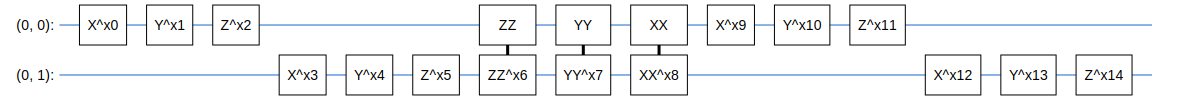

In [ ]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

In [ ]:
bits=cirq.GridQubit.rect(4,4)
for first, second in zip(bits[0::2], bits[1::2] ):
  print(first, second)

(0, 0) (0, 1)
(0, 2) (0, 3)
(1, 0) (1, 1)
(1, 2) (1, 3)
(2, 0) (2, 1)
(2, 2) (2, 3)
(3, 0) (3, 1)
(3, 2) (3, 3)


In [ ]:
qubits16=cirq.GridQubit.rect(4,4)
def conv_circuit(bits, symbols):
  circuit=cirq.Circuit()
  image=np.array(bits).reshape((4,4))
  for j in range(0,4,2):
    for k in range(0,4,2):
      circuit +=two_qubit_unitary([image[j,k],image[j,k+1] ], symbols)
      circuit+= two_qubit_unitary([ image[j+1, k], image[j+1, k+1]],symbols)
  return circuit

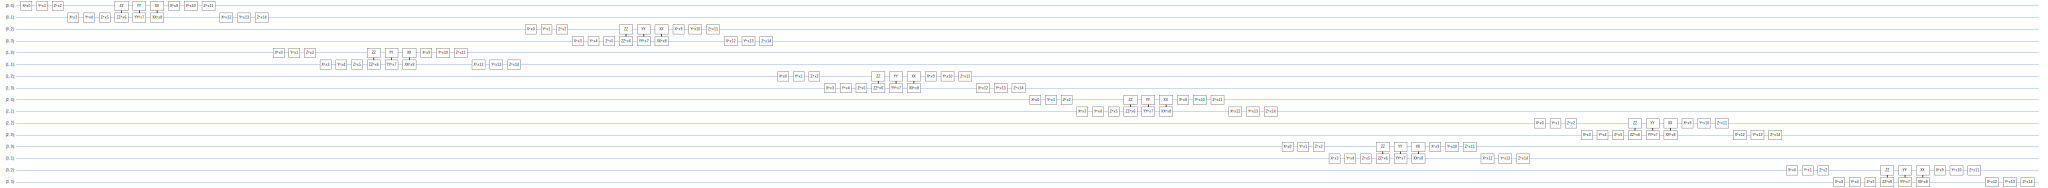

In [ ]:
SVGCircuit(conv_circuit(qubits16,sympy.symbols('x0:15')))

In [ ]:
def create_model(qubits):
  model_circuit=cirq.Circuit()
  symbols=sympy.symbols('qconv0:15')
  model_circuit+=conv_circuit(qubits, symbols)
  return model_circuit

qubits36=cirq.GridQubit.rect(4,4)
readout_operators=cirq.Z(qubits36[-1])

model=tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype=tf.string), 
                           tfq.layers.PQC(create_model(qubits36), readout_operators)])



In [ ]:
#encode images to quantum states

def encode_circuit_16(values):
  phi=np.ndarray.flatten(values)
  encode_circuit=cirq.Circuit()
  qubits=cirq.GridQubit.rect(4,4)
  for i in range(16):
    encode_circuit.append(cirq.ry(np.pi*phi[i])(qubits[i]))
  return encode_circuit

In [ ]:
x_train_16=[encode_circuit_16(x) for x in x_train]
x_test_16=[encode_circuit_16(x) for x in x_test]

In [ ]:
xx_train_16=tfq.convert_to_tensor(x_train_16)
xx_test_16=tfq.convert_to_tensor(x_test_16)

In [ ]:
@tf.function
def custom_accuracy(y_true, y_pred):
  y_true=tf.squeeze(y_true)
  y_pred=tf.map_fn(lambda x: 1.0 if x>=0 else -1.0, y_pred)
  return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
"""
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])
"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.Hinge(),
                   metrics=[hinge_accuracy])

In [ ]:
history = model.fit(x=xx_train_16,
                         y=np.asarray(Y_train),
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(xx_test_16, np.asarray(Y_test)))

Epoch 1/25
7/7 [==============================] - 5s 701ms/step - loss: 0.4939 - hinge_accuracy: 0.8750 - val_loss: 0.9529 - val_hinge_accuracy: 0.6875
Epoch 2/25
7/7 [==============================] - 5s 677ms/step - loss: 0.4522 - hinge_accuracy: 0.8661 - val_loss: 0.9884 - val_hinge_accuracy: 0.6875
Epoch 3/25
7/7 [==============================] - 5s 674ms/step - loss: 0.4289 - hinge_accuracy: 0.8571 - val_loss: 0.9863 - val_hinge_accuracy: 0.6875
Epoch 4/25
7/7 [==============================] - 5s 683ms/step - loss: 0.4228 - hinge_accuracy: 0.8571 - val_loss: 0.9705 - val_hinge_accuracy: 0.6875
Epoch 5/25
7/7 [==============================] - 5s 669ms/step - loss: 0.4175 - hinge_accuracy: 0.8125 - val_loss: 0.9672 - val_hinge_accuracy: 0.6875
Epoch 6/25
7/7 [==============================] - 5s 671ms/step - loss: 0.4180 - hinge_accuracy: 0.8393 - val_loss: 0.9652 - val_hinge_accuracy: 0.6875
Epoch 7/25
7/7 [==============================] - 5s 677ms/step - loss: 0.4173 - hinge_a

In [ ]:
preds=model.predict_classes(xx_test_16)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


-1.0
Prediction: [0]


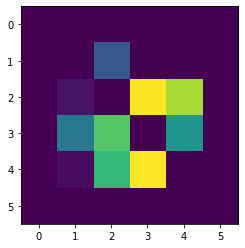

1.0
Prediction: [0]


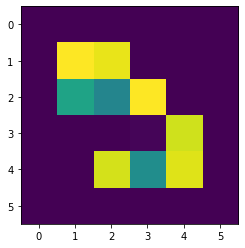

-1.0
Prediction: [0]


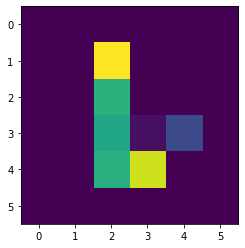

-1.0
Prediction: [0]


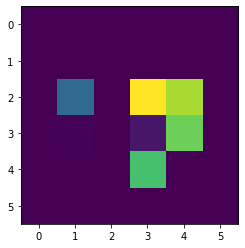

1.0
Prediction: [0]


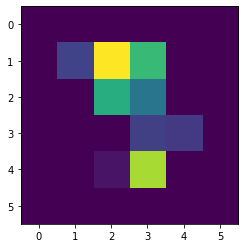

1.0
Prediction: [0]


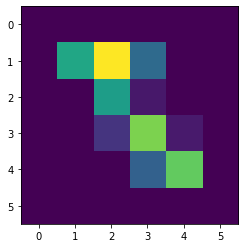

1.0
Prediction: [0]


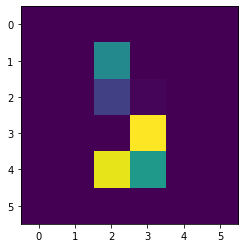

-1.0
Prediction: [0]


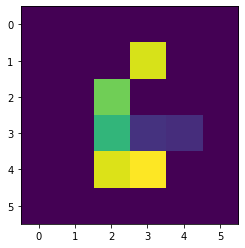

1.0
Prediction: [0]


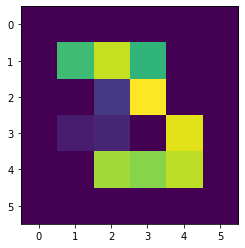

-1.0
Prediction: [0]


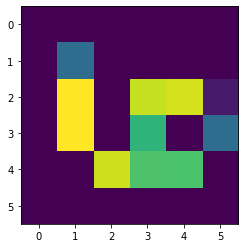

1.0
Prediction: [0]


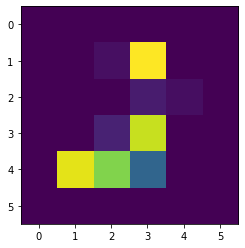

-1.0
Prediction: [0]


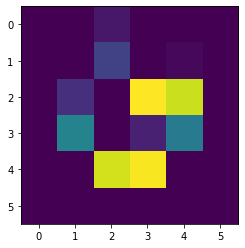

1.0
Prediction: [0]


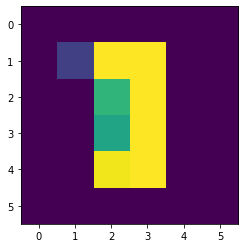

1.0
Prediction: [0]


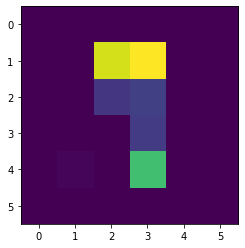

-1.0
Prediction: [0]


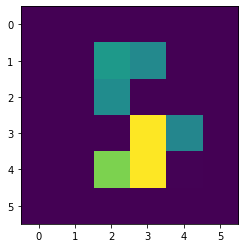

1.0
Prediction: [0]


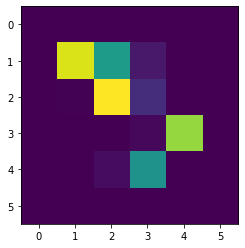

-1.0
Prediction: [0]


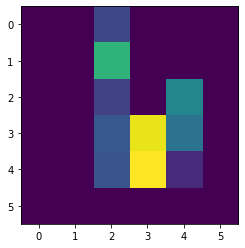

1.0
Prediction: [0]


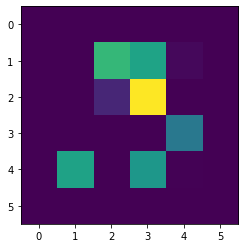

-1.0
Prediction: [0]


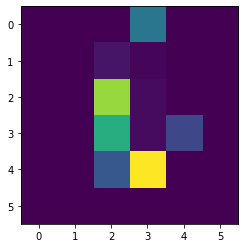

1.0
Prediction: [0]


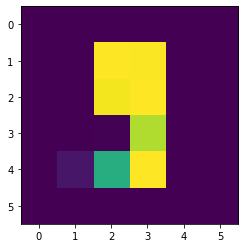

In [ ]:
for i in range(len(X_test)):
  print(Y_test[i])
  print('Prediction:', preds[i])
  plt.imshow(X_test[i,:,:,0])
  plt.show()

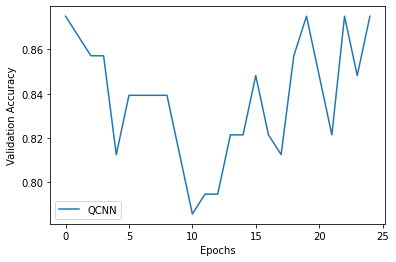

In [ ]:
plt.plot(history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()